In [44]:
import pickle
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, average_precision_score
from algo.module import pearson_corr_coef
import matplotlib.pyplot as plt

In [45]:
# modify the path here
with open('/home/ubuntu/SeqHiC2RNA/output/model_output/hcformer_pbulk/baseline/baseline_test_ahr49sz0.pkl', 'rb') as f:
    baseline_test_output = pickle.load(f)
with open('/home/ubuntu/SeqHiC2RNA/output/model_output/hcformer_pbulk/baseline/baseline_valid_ahr49sz0.pkl', 'rb') as f:
    baseline_valid_output = pickle.load(f)

with open('/home/ubuntu/SeqHiC2RNA/output/model_output/hcformer_pbulk/hic1d/hic1d_test_ai9o5a06.pkl', 'rb') as f:
    hic1d_test_output = pickle.load(f)
with open('/home/ubuntu/SeqHiC2RNA/output/model_output/hcformer_pbulk/hic1d/hic1d_valid_ai9o5a06.pkl', 'rb') as f:
    hic1d_valid_output = pickle.load(f)

with open('/home/ubuntu/SeqHiC2RNA/output/model_output/hcformer_pbulk/hic2d/hic2d_test_awasqs3z.pkl', 'rb') as f:
    hic2d_test_output = pickle.load(f)

with open('/home/ubuntu/SeqHiC2RNA/output/model_output/hcformer_pbulk/hic2d/hic2d_valid_awasqs3z.pkl', 'rb') as f:
    hic2d_valid_output = pickle.load(f)

with open('/home/ubuntu/SeqHiC2RNA/output/model_output/hcformer_pbulk/hic1d2d/hic1d2d_test_d1xcmvsr.pkl', 'rb') as f:
    hic1d2d_test_output = pickle.load(f)

with open('/home/ubuntu/SeqHiC2RNA/output/model_output/hcformer_pbulk/hic1d2d/hic1d2d_valid_d1xcmvsr.pkl', 'rb') as f:
    hic1d2d_valid_output = pickle.load(f)


# do not need to modify
with open('/home/ubuntu/SeqHiC2RNA/output/model_output/hcformer_pbulk/test_expression.pkl', 'rb') as f:
    test_exp = pickle.load(f)

with open('/home/ubuntu/SeqHiC2RNA/output/model_output/hcformer_pbulk/valid_expression.pkl', 'rb') as f:
    valid_exp = pickle.load(f)

In [46]:
def all_pcc(x, y, dim = 0, reduce_dims = 0):
    x_centered = x - x.mean(dim = dim, keepdim = True)
    y_centered = y - y.mean(dim = dim, keepdim = True)
    return F.cosine_similarity(x_centered, y_centered, dim = dim).mean(dim = reduce_dims)

print(all_pcc(baseline_valid_output.reshape(-1,), valid_exp.reshape(-1, )))
print(all_pcc(hic1d_valid_output.reshape(-1,), valid_exp.reshape(-1, )))
print(all_pcc(hic2d_valid_output.reshape(-1,), valid_exp.reshape(-1, )))
print(all_pcc(hic1d2d_valid_output.reshape(-1,), valid_exp.reshape(-1, )))

print(all_pcc(baseline_test_output.reshape(-1,), test_exp.reshape(-1, )))
print(all_pcc(hic1d_test_output.reshape(-1,), test_exp.reshape(-1, )))
print(all_pcc(hic2d_test_output.reshape(-1,), test_exp.reshape(-1, )))
print(all_pcc(hic1d2d_test_output.reshape(-1,), test_exp.reshape(-1, )))

tensor(0.5276)
tensor(0.5611)
tensor(0.5561)
tensor(0.5747)
tensor(0.4586)
tensor(0.4981)
tensor(0.4939)
tensor(0.5228)


In [47]:
def cal_gene_wise(data, num_genes):
    data = data.squeeze()
    new_data = torch.zeros(num_genes, int(data.shape[0]/num_genes * 240))
    for i in range(num_genes):
        new_data[i] = data[i::num_genes].reshape(1, -1)
    return new_data

tensor(0.3347)
tensor(0.3687)
tensor(0.3609)
tensor(0.3793)


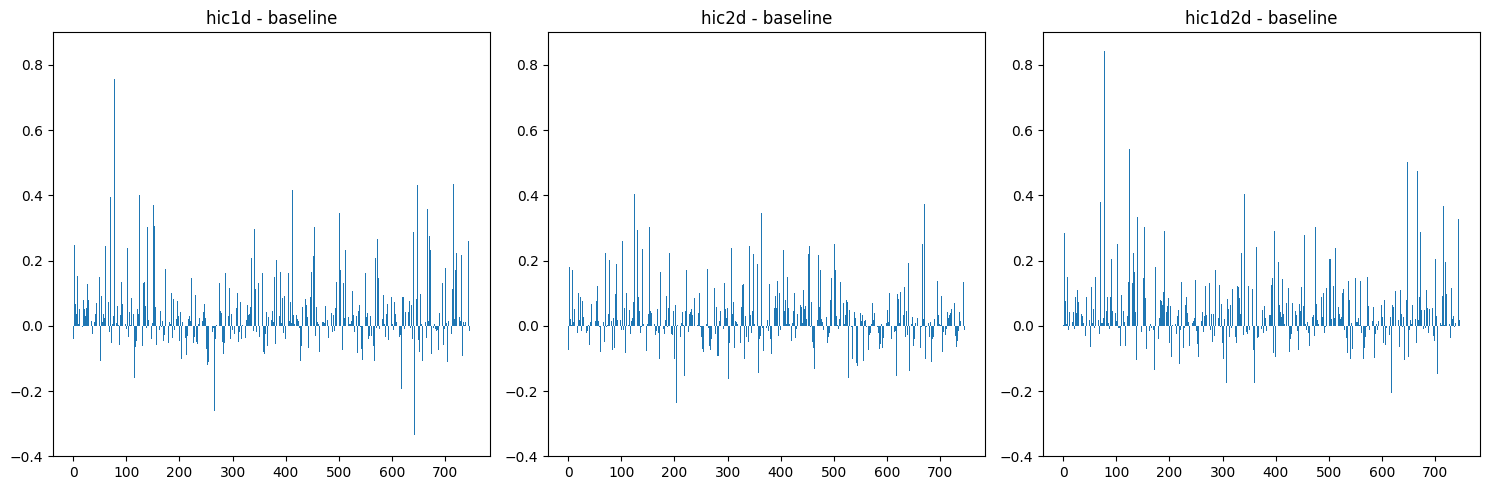

In [73]:
def arr_pcc(x, y, dim = 1, reduce_dims = 0):
    x_centered = x - x.mean(dim = dim, keepdim = True)
    y_centered = y - y.mean(dim = dim, keepdim = True)
    return F.cosine_similarity(x_centered, y_centered, dim = dim)

baseline_test_output_gene = cal_gene_wise(baseline_test_output, 748)
hic1d_test_output_gene = cal_gene_wise(hic1d_test_output, 748)
hic2d_test_output_gene = cal_gene_wise(hic2d_test_output, 748)
hic1d2d_test_output_gene = cal_gene_wise(hic1d2d_test_output, 748)
test_exp_gene = cal_gene_wise(test_exp, 748)

diff1d = arr_pcc(hic1d_test_output_gene, test_exp_gene) - arr_pcc(baseline_test_output_gene, test_exp_gene)
diff2d = arr_pcc(hic2d_test_output_gene, test_exp_gene) - arr_pcc(baseline_test_output_gene, test_exp_gene)
diff1d2d = arr_pcc(hic1d2d_test_output_gene, test_exp_gene) - arr_pcc(baseline_test_output_gene, test_exp_gene)
print(arr_pcc(baseline_test_output_gene, test_exp_gene).mean())
print(arr_pcc(hic1d_test_output_gene, test_exp_gene).mean())
print(arr_pcc(hic2d_test_output_gene, test_exp_gene).mean())
print(arr_pcc(hic1d2d_test_output_gene, test_exp_gene).mean())


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
y_limits = [-0.4, 0.9]
axs[0].bar(range(len(diff1d)), diff1d)
axs[0].set_ylim(y_limits)
axs[0].set_title('hic1d - baseline')
axs[1].bar(range(len(diff2d)), diff2d)
axs[1].set_ylim(y_limits)
axs[1].set_title('hic2d - baseline')
axs[2].bar(range(len(diff1d2d)), diff1d2d)
axs[2].set_ylim(y_limits)
axs[2].set_title('hic1d2d - baseline')
plt.tight_layout()


In [106]:
set1d_bad = set(torch.where(diff1d<-0.1)[0].numpy())
set2d_bad = set(torch.where(diff2d<-0.1)[0].numpy())
set1d2d_bad = set(torch.where(diff1d2d<-0.1)[0].numpy())

set1d_good = set(torch.where(diff1d>0.2)[0].numpy())
set2d_good = set(torch.where(diff2d>0.2)[0].numpy())
set1d2d_good = set(torch.where(diff1d2d>0.2)[0].numpy())


print(set1d2d_bad & (set1d_good | set2d_good))
print(diff2d[307])
print(diff1d[307])
print(diff1d2d[307])


{307}
tensor(0.2394)
tensor(0.0559)
tensor(-0.1766)


In [83]:
set1d = set(torch.where(diff1d>0.2))
set2d = set(torch.where(diff2d>0.2))
set1d2d = set(torch.where(diff1d2d>0.2))

print(set1d)
print(set2d)
print(set1d2d)
print(set1d - set2d)
print(set1d2d - set1d)
print(set1d2d - set2d)

{tensor([  2,  33,  61,  70,  78,  96,  99, 102, 125, 140, 151, 153, 154, 159,
        193, 218, 233, 244, 336, 341, 342, 350, 383, 406, 413, 450, 452, 454,
        487, 489, 501, 513, 568, 569, 573, 587, 593, 613, 641, 648, 657, 661,
        662, 667, 671, 673, 691, 716, 722, 731, 734, 744])}
{tensor([ 46,  70,  78,  96, 102, 125, 130, 140, 153, 154, 159, 191, 193, 207,
        218, 233, 306, 307, 312, 341, 342, 349, 364, 405, 418, 448, 450, 452,
        453, 454, 455, 465, 471, 501, 502, 510, 587, 593, 613, 628, 629, 659,
        667, 671, 683])}
{tensor([  2,  46,  65,  70,  78,  91,  96,  99, 102, 125, 132, 140, 153, 154,
        159, 191, 193, 207, 218, 233, 244, 306, 312, 327, 336, 341, 342, 350,
        364, 371, 398, 448, 453, 454, 455, 465, 475, 487, 489, 501, 503, 513,
        515, 572, 587, 593, 613, 629, 648, 659, 662, 667, 672, 673, 691, 701,
        716, 734, 744])}
{tensor([  2,  33,  61,  70,  78,  96,  99, 102, 125, 140, 151, 153, 154, 159,
        193, 218, 233, 244, 

In [3]:
print(pearson_corr_coef(hic1d_valid_output, valid_exp)[0])
print(pearson_corr_coef(hic1d2d_valid_output, valid_exp)[0])
test_exp = test_exp != 0
test_exp = test_exp.int()
valid_exp = valid_exp != 0
valid_exp = valid_exp.int()
print(roc_auc_score(test_exp.reshape(-1, ), baseline_test_output.reshape(-1, )))
print(roc_auc_score(test_exp.reshape(-1, ), hic1d_test_output.reshape(-1, )))
print(roc_auc_score(test_exp.reshape(-1, ), hic2d_test_output.reshape(-1, )))
print(roc_auc_score(test_exp.reshape(-1, ), hic1d2d_test_output.reshape(-1, )))
print(roc_auc_score(valid_exp.reshape(-1, ), baseline_valid_output.reshape(-1, )))
print(roc_auc_score(valid_exp.reshape(-1, ), hic1d_valid_output.reshape(-1, )))
print(roc_auc_score(valid_exp.reshape(-1, ), hic2d_valid_output.reshape(-1, )))
print(roc_auc_score(valid_exp.reshape(-1, ), hic1d2d_valid_output.reshape(-1, )))

print(average_precision_score(test_exp.reshape(-1, ), baseline_test_output.reshape(-1, )))
print(average_precision_score(test_exp.reshape(-1, ), hic1d_test_output.reshape(-1, )))
print(average_precision_score(test_exp.reshape(-1, ), hic2d_test_output.reshape(-1, )))
print(average_precision_score(test_exp.reshape(-1, ), hic1d2d_test_output.reshape(-1, )))
print(average_precision_score(valid_exp.reshape(-1, ), baseline_valid_output.reshape(-1, )))
print(average_precision_score(valid_exp.reshape(-1, ), hic1d_valid_output.reshape(-1, )))
print(average_precision_score(valid_exp.reshape(-1, ), hic2d_valid_output.reshape(-1, )))
print(average_precision_score(valid_exp.reshape(-1, ), hic1d2d_valid_output.reshape(-1, )))

tensor(0.4154)
tensor(0.4122)
0.855770839088449
0.874154087056129
0.8721926601724128
0.8813068643735342
0.8877243326421507
0.9011123625970092
0.8990566833505887
0.9043111194714523
0.4303101539443735
0.4560428921967422
0.46532331115065234
0.48753941567808334
0.5070478088930294
0.5347871110399897
0.5368905900117596
0.5575873660763565


In [4]:
def cal_auc_array(pred, gt):
    auc_scores = torch.zeros(pred.shape[0])
    for i in range(pred.shape[0]):
        auc_scores[i] = roc_auc_score(gt[i], pred[i])
    return auc_scores

def cal_auprc_array(pred, gt):
    auprc_scores = torch.zeros(pred.shape[0])
    for i in range(pred.shape[0]):
        auprc_scores[i] = average_precision_score(gt[i], pred[i])
    return auprc_scores

In [5]:
import matplotlib.pyplot as plt

colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
num_colors = len(colors)

group_size = 748

def plot(data):
    for i in range(0, len(data), group_size):
        plt.bar(range(i, min(i + group_size, len(data))), data[i:i + group_size], color=colors[i // group_size % num_colors])

/opt/conda/envs/seq/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/envs/seq/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/envs/seq/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/envs/seq/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/envs/seq/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/conda/envs/seq/lib/python3.10/site-packages/sklearn/met

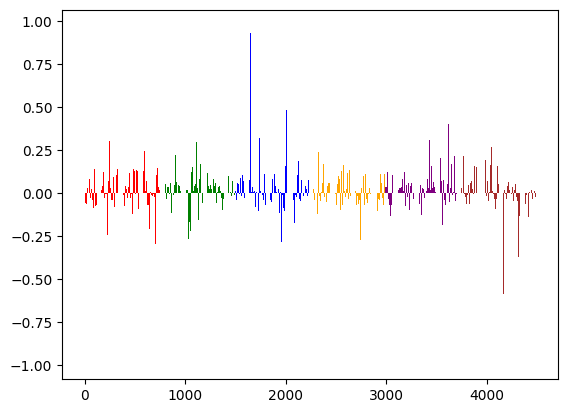

In [8]:
baseline_test_auprc_array = cal_auprc_array(baseline_test_output.squeeze(), test_exp.squeeze())
hic1d2d_test_auprc_array = cal_auprc_array(hic1d2d_test_output.squeeze(), test_exp.squeeze())
diff = hic1d2d_test_auprc_array - baseline_test_auprc_array
plot(diff)
plt.show()


In [10]:
print(diff.mean())
print(baseline_test_auprc_array.mean())
print(hic1d2d_test_auprc_array.mean())
print(average_precision_score(test_exp.reshape(-1, ), baseline_test_output.reshape(-1, )))
print(average_precision_score(test_exp.reshape(-1, ), hic1d2d_test_output.reshape(-1, )))

tensor(0.0175)
tensor(0.3764)
tensor(0.3939)
0.4303101539443735
0.48753941567808334
